# Service types provision assessment

In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

In [2]:
from blocksnet.models import City
city_model = City.from_pickle('rus_spb.pickle')

In [3]:
from blocksnet.method import Provision
prov = Provision(city_model=city_model)

In [40]:
blocks_gdf = prov._get_blocks_gdf(city_model['kindergarten'])

In [49]:
def upper_bound(gdf):
  capacity = gdf['capacity'].sum()
  demand = gdf['demand'].sum()
  return min(capacity/demand, 1)

def lower_bound(gdf):
  gdf = gdf.copy()
  gdf['demand_within'] = gdf.apply(lambda x : min(x['capacity'], x['demand']),axis=1)
  return gdf['demand_within'].sum()/gdf['demand'].sum()

print(lower_bound(blocks_gdf), upper_bound(blocks_gdf))


0.6130115184047479 0.9809394927170703


In [64]:
def var_to_names(name):
  name = name.replace("(", "").replace(")", "").replace(",", "").split("_")
  return name[1], name[2]

df = pd.DataFrame([var.to_dict() for var in vars])
df['from'] = df['name'].apply(lambda x : var_to_names(x)[0]).apply(int)
df['to'] = df['name'].apply(lambda x : var_to_names(x)[1]).apply(int)

In [66]:
df = df.loc[df['from'] != 3839]
df = df.loc[df['to'] != 3839]

In [69]:
from math import sqrt

df['is_accessible'] = df['dj'].apply(sqrt).apply(lambda x : x<=city_model['kindergarten'].accessibility)

In [77]:
gdf = prov._get_blocks_gdf(city_model['kindergarten'])

In [78]:
gdf

,geometry,capacity,demand,demand_left,demand_within,demand_without,capacity_left
id,,,,,,,
0,"POLYGON ((21256.898 6676646.063, 21256.898 667...",560,176,176,0,0,560
1,"POLYGON ((21579.273 6676542.669, 21569.628 667...",0,2,2,0,0,0
2,"POLYGON ((15519.724 6685090.109, 15537.179 668...",280,258,258,0,0,280
3,"POLYGON ((23226.132 6680490.489, 23203.720 668...",0,134,134,0,0,0
4,"POLYGON ((23190.502 6680401.003, 23193.601 668...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
3834,"POLYGON ((16971.005 6683010.295, 16928.042 668...",0,0,0,0,0,0
3835,"POLYGON ((17617.836 6662709.760, 17622.174 666...",0,0,0,0,0,0
3836,"POLYGON ((24097.913 6661657.331, 24122.154 666...",0,0,0,0,0,0


In [85]:
gdf['demand_within'] = df.loc[df.is_accessible].groupby('from').agg({'varValue':'sum'})['varValue'].apply(int)
gdf['demand_without'] = df.loc[~df.is_accessible].groupby('from').agg({'varValue':'sum'})['varValue'].apply(int)
gdf['capacity_left'] = gdf['capacity'] - df.loc[~df.is_accessible].groupby('from').agg({'varValue':'sum'})['varValue'].apply(int)

In [89]:
gdf['provision'] = gdf['demand_within'] / gdf['demand']

<Axes: title={'center': 'Provision:  0.937'}>

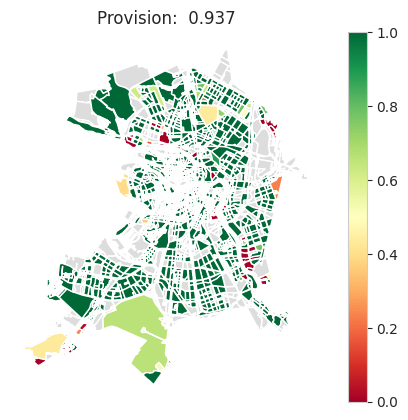

In [91]:
prov.plot(gdf)

In [5]:
import pandas as pd

update = {
  148: {
    'population': 10000,
  }
}

update_df = pd.DataFrame.from_dict(update, orient='index')

In [6]:
calc_after, weights_after = prov.calculate('kindergartens', update_df=update_df, method='gravity')
ax = prov.plot(calc_after)
weights_gdf = prov.weights_to_gdf(weights_after)
weights_gdf.plot(column='weight', ax=ax)

KeyError: "Can't find service type with such name: kindergartens"

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


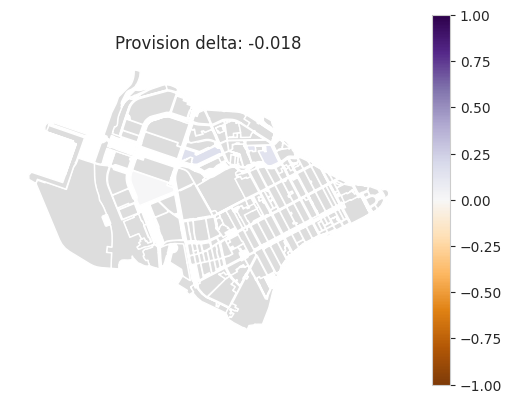

In [ ]:
prov.plot_delta(calc_before, calc_after)

In [ ]:
Provision.stat_provision(calc_before)

{'mean': 0.5986625218033782, 'median': 1.0, 'min': 0.0, 'max': 1.0}

In [ ]:
Provision.stat_provision(calc_after)

{'mean': 0.6010412227397885, 'median': 1.0, 'min': 0.0, 'max': 1.0}

In [ ]:
demand = calc_after.demand.sum()
capacity = calc_after.capacity.sum()
capacity/demand

0.7819813084112149

In [ ]:
scenario = {'schools': 0.5, 'kindergartens': 0.5}
gdf, total = prov.calculate_scenario(scenario)
print(total)

0.6709120101908853
